In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
import os
import gcsfs
fs = gcsfs.GCSFileSystem()

%run _Val_Mapping.ipynb

In [2]:
#Search LEAP persistent bucket
#fs.ls('gs://leap-persistent/')

In [3]:
spco2_mems_dict = {'ACCESS-ESM1-5': ['member_r4i1p1f1'], 'CESM2': ['member_r4i1p1f1'], 'CESM2-WACCM': ['member_r3i1p1f1'],
             'CMCC-ESM2': ['member_r1i1p1f1'], 'CanESM5': ['member_r9i1p2f1'], 'CanESM5-CanOE': ['member_r1i1p2f1'],
             'GFDL-ESM4': ['member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r11i1p1f1'], 'UKESM1-0-LL': ['member_r1i1p1f2']}

# Members that output sea level pressure
pres_mems_dict = {'ACCESS-ESM1-5': ['member_r9i1p1f1'], 'CESM2': ['member_r4i1p1f1'], 'CESM2-WACCM': ['member_r3i1p1f1'],
             'CMCC-ESM2': ['member_r1i1p1f1'], 'CanESM5': ['member_r9i1p2f1'], 'CanESM5-CanOE': ['member_r1i1p2f1'],
             'GFDL-ESM4': ['member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r5i1p1f1'], 'UKESM1-0-LL': ['member_r13i1p1f2']}

# 45-member testbed

In [4]:
regridded_members_path = "gs://leap-persistent/abbysh/pco2_all_members_1982-2016/post00_regridded_members"

recon_mems_dict = dict()
a = fs.ls(regridded_members_path)
for ens_path in a:
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:
        memo = mem.split('/')[-1]
        
        if ens not in recon_mems_dict:
            recon_mems_dict[ens] = [memo]

        elif ens in recon_mems_dict:
            recon_mems_dict[ens].append(memo)

In [5]:
pres_dir = 'gs://leap-persistent/abbysh/pco2_cmip6_psl_198202-202212/post00_regridded_members'
spco2_dir = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post00_regridded_members'
xco2_path = "gs://leap-persistent/abbysh/zarr_files_/xco2_cmip6_183501-224912.zarr"
seaflux_file_path = 'gs://leap-persistent/galenmckinley/online_data/SeaFlux/originals/SeaFlux_LDEO_SeaFlux-v202301-all_1982-2022.zarr'

In [6]:
def model_data_prep(model, spco2_member, pres_member, xco2_path, spco2_dir, pres_dir):

    ## spco2 ##
    spco2_ds_paths = fs.glob(f'{spco2_dir}/{model}/{spco2_member}/{model}*.zarr')
    spco2_ds = xr.open_dataset('gs://'+spco2_ds_paths[0], engine='zarr')
    spco2 = spco2_ds.spco2

    ## xco2 ##
    xco2_ds = xr.open_dataset(xco2_path,engine='zarr')
    xco2 = xco2_ds.xco2.sel(time=slice("1982-02-15",'2022-12-15'))

    ## pressure ##
    pres_ds_paths = fs.glob(f'{pres_dir}/{model}/{pres_member}/{model}*.zarr')

    pres_ds = xr.open_dataset('gs://'+ pres_ds_paths[0], engine='zarr')
    pres = pres_ds.psl
    pres = pres.where(pres > 0, np.nan)

    ## ensure they all have the same time ##
    pres['time'] = spco2['time']
    xco2['time'] = spco2['time']

    ## Convert from pascals to uatm ##
    pres2 = pres/101325

    ## calculate atm without water vapor correction
    atm_nocorr = pres2 * xco2

    ## make land values nans ##
    atm_nocorr = atm_nocorr.where(spco2.notnull(), -1000)
    atm_nocorr = atm_nocorr.where(atm_nocorr != -1000) 

    ## latitude weighting
    weights = np.cos(np.deg2rad(spco2.ylat))
    weights.name = "weights"

    return atm_nocorr,weights

In [7]:
def flux_calculation_general(ds_truth_unseen, model_pco2atm, seaflux_file_path):
    
    # replacing 0s with nans
    ds_truth_unseen = ds_truth_unseen.where(ds_truth_unseen != 0.)
    
    recon_ens = ds_truth_unseen

    # define dates and times
    start_yearmonth = str(recon_ens.time.min().data.astype('datetime64[s]').item().strftime('%Y-%m'))
    end_yearmonth = str(recon_ens.time.max().data.astype('datetime64[s]').item().strftime('%Y-%m'))
    print(f'{start_yearmonth} to {end_yearmonth}')

    # get winds
    seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
    kw1 = seaflux.kw.sel(wind=["ERA5"])

    kw = kw1 * 87.6  # --> cm/hr now m/yr
    kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
                            #should always be over 0 so this prevents againsts issues in other releases
                            #update so that kw1 is nan if 0 ever (so mean is not too low)
    
    q = seaflux['sol'][400,:,:].mean().values
    if q > 0.001: 
        k0 = (seaflux.sol)/1000
    else:
        k0 = seaflux.sol
        
    icef = seaflux.ice # ice fraction 
    ice_weighting = 1 - icef.fillna(0)
    
    #filter to same time frame
    k0_filter = k0.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
    kw_filter = kw.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
    ice_weighting_filter = ice_weighting.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

    #Process reconstructed pco2
    recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')  
    recon_ens['time'] = k0_filter['time'] 
    
    lon2 = np.where(recon_ens.xlon>180,recon_ens.xlon-360,recon_ens.xlon)
    recon_ens['xlon'] = (lon2)
    recon_ens = recon_ens.sortby(recon_ens.xlon)
    
    if True: 
        pco2_ens = recon_ens.rename({'xlon': 'lon'})
        pco2_ens = pco2_ens.rename({'ylat': 'lat'})
        pco2_ens = pco2_ens.transpose('time','lat','lon',...)
    
    spco2_ens = pco2_ens
    
    model_pco2atm['time'] = model_pco2atm.time.data.astype('datetime64[s]')
    model_pco2atm['time'] = recon_ens['time']

    lon2 = np.where(model_pco2atm.xlon>180,model_pco2atm.xlon-360,model_pco2atm.xlon)
    model_pco2atm['xlon'] = (lon2)
    model_pco2atm = model_pco2atm.sortby(model_pco2atm.xlon)
    
    if True: 
        pco2atm = model_pco2atm.rename({'xlon': 'lon'})
        pco2atm = pco2atm.rename({'ylat': 'lat'})
        pco2atm = pco2atm.transpose('time','lat','lon',...)
    
    pco2atm2 = pco2atm

    delta_ens = spco2_ens - pco2atm2

    #calculate flux
    flux_ens_model =(k0_filter
                * kw_filter
                * delta_ens 
                * ice_weighting_filter
               ) # mol/m2/yr

    #remove flux calc for unmasked area for truth reconstruction 
    flux_truth_raw = flux_ens_model.sel(status="truth")
    flux_recon_raw = flux_ens_model.sel(status="unseen")

    # want to put the nans from reconstruction into truth  
    flux_truth_masked = xr.where(flux_recon_raw.notnull(),flux_truth_raw,-1000)
    flux_truth_masked = flux_truth_masked.where(flux_truth_masked != -1000)
    
    flux_truth = flux_truth_masked
    flux_recon = flux_recon_raw 

    return flux_truth,flux_recon

## Testbed pCO2 reconstructions and truth

In [8]:
def calculate_flux_using_recons(recon_mems_dict, recon_dir):
    
    truth_fluxes = []
    recon_fluxes = []
    
    for ens, mem_list in recon_mems_dict.items():
        datasets_member = []
        for n_member, member in enumerate(mem_list):

            truth_path = f'gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'

            recon_path = f"{recon_dir}/{ens}/{member}/xg_recon_pCO2_{ens}_{member}_mon_1x1_198202_202212.zarr"

            kwargs = dict(chunks={'time':-1})
                        
            truth = xr.open_dataset(truth_path, engine='zarr',**kwargs).spco2 
            unseen = xr.open_dataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen 
            
            
            unseen = unseen.sel(time=slice("1982-02-01",'2022-12-31'))
           
            # assign_dimension coordinates
            truth = truth.assign_coords(status='truth')
            unseen = unseen.assign_coords(status='unseen')
            
            # make sure they have the same time coordinates
            truth = truth.assign_coords(time=unseen['time'].data)
            
            member_ds = xr.concat([truth, unseen], dim='status')
            
            # add member_dimension and coordinate
            member_ds = member_ds.assign_coords(n_member=n_member, member=member)
            
            datasets_member.append(member_ds)
    
            spco2_mem_list = spco2_mems_dict[ens]
            pres_mem_list = pres_mems_dict[ens]
    
            atm_nocorr, weights = model_data_prep(ens, spco2_mem_list[0], pres_mem_list[0], xco2_path, spco2_dir, pres_dir)
    
            flux_truth,flux_recon = flux_calculation_general(member_ds, atm_nocorr, seaflux_file_path)
            
            truth_fluxes.append(flux_truth)
            recon_fluxes.append(flux_recon)
            
    return truth_fluxes,recon_fluxes,weights

## nMSE_Run

In [9]:
socat_baseline_recon_dir = 'gs://leap-persistent/abbysh/pco2_gridsearch_1982-2022/post02_xgb_1982-2022_nmse_outputs/reconstructions'
flux_truth_socat_baseline,flux_recon_socat_baseline,weights = calculate_flux_using_recons(recon_mems_dict, socat_baseline_recon_dir)

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

## testbed mean

In [10]:
# Testbed reconstruction
fluxes_socat_baseline = []
for ds in flux_recon_socat_baseline:
    fluxes_socat_baseline.append(ds.values)
testbed_mean_flux_socat_baseline = np.mean(fluxes_socat_baseline,axis=0)

In [11]:
# Testbed truth
fluxes_truth = []
for ds in flux_truth_socat_baseline:
    fluxes_truth.append(ds.values)
testbed_mean_flux_truth = np.mean(fluxes_truth,axis=0)

In [12]:
# Testbed reconstruction
testbed_mean_flux_socat_baseline_xr = xr.DataArray(
    data=testbed_mean_flux_socat_baseline[:,:,:,0],
    dims=["time", "ylat", "xlon"],
    coords=dict(
        time=flux_recon_socat_baseline[0].time.values,
        ylat=flux_recon_socat_baseline[0].lat.values,
        xlon=flux_recon_socat_baseline[0].lon.values,
    ))

In [13]:
# Testbed truth
testbed_mean_flux_truth_xr = xr.DataArray(
    data=testbed_mean_flux_truth[:,:,:,0],
    dims=["time", "ylat", "xlon"],
    coords=dict(
        time=flux_recon_socat_baseline[0].time.values,
        ylat=flux_recon_socat_baseline[0].lat.values,
        xlon=flux_recon_socat_baseline[0].lon.values,
    ))

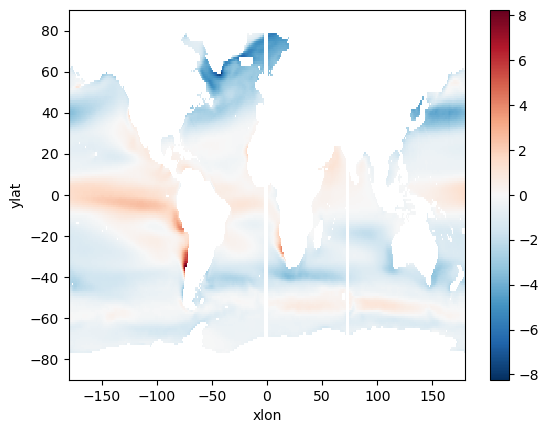

In [16]:
testbed_mean_flux_socat_baseline_xr.mean('time').plot()

### Remove vertical lines of nans

In [14]:
#Testbed reconstructions
testbed_mean_flux_socat_baseline_xr[0,40,181].values
testbed_mean_flux_socat_baseline_xr[:,:,180] = testbed_mean_flux_socat_baseline_xr[:,:,181]
testbed_mean_flux_socat_baseline_xr[:,:,179] = testbed_mean_flux_socat_baseline_xr[:,:,181]
testbed_mean_flux_socat_baseline_xr[:,:,178] = testbed_mean_flux_socat_baseline_xr[:,:,181]
testbed_mean_flux_socat_baseline_xr[:,:,177] = testbed_mean_flux_socat_baseline_xr[:,:,176]

testbed_mean_flux_truth_xr[:,:,180] = testbed_mean_flux_truth_xr[:,:,181]
testbed_mean_flux_truth_xr[:,:,179] = testbed_mean_flux_truth_xr[:,:,181]
testbed_mean_flux_truth_xr[:,:,178] = testbed_mean_flux_truth_xr[:,:,181]
testbed_mean_flux_truth_xr[:,:,177] = testbed_mean_flux_truth_xr[:,:,176]

In [15]:
#Testbed truth
testbed_mean_flux_socat_baseline_xr[0,40,252].values
testbed_mean_flux_socat_baseline_xr[:,:,252] = testbed_mean_flux_socat_baseline_xr[:,:,251]
testbed_mean_flux_socat_baseline_xr[:,:,253] = testbed_mean_flux_socat_baseline_xr[:,:,254]

testbed_mean_flux_truth_xr[:,:,252] = testbed_mean_flux_truth_xr[:,:,251]
testbed_mean_flux_truth_xr[:,:,253] = testbed_mean_flux_truth_xr[:,:,254]

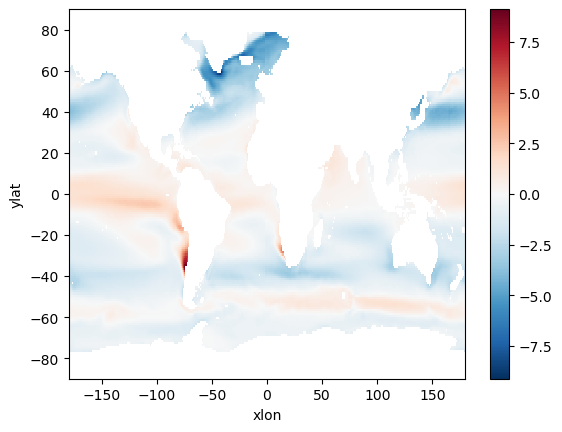

In [27]:
testbed_mean_flux_truth_xr.mean('time').plot()

## Calculate flux in Pg/yr

### Globally

In [16]:
# Testbed reconstruction
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_recon_socat_baseline
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() 
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_socat = final_flux

In [17]:
# Testbed truth
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_truth_socat_baseline
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() 
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_truth = final_flux

### Southern Ocean

In [26]:
# Testbed reconstruction
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_recon_socat_baseline
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() 
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_tmp2 = flux_tmp2.sel(lat=slice(-90,-35))
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_socat_SO = final_flux

In [27]:
# Testbed truth
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_truth_socat_baseline
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() 
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_tmp2 = flux_tmp2.sel(lat=slice(-90,-35))
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_truth_SO = final_flux

## Optimized_Run

In [18]:
optimized_recon_path = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post02_xgb_outputs_val_params/reconstructions'
flux_truth_optimized,flux_recon_optimized,weights = calculate_flux_using_recons(recon_mems_dict, optimized_recon_path)

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

## Testbed mean

In [19]:
fluxes_optimized = []
for ds in flux_recon_optimized:
    fluxes_optimized.append(ds.values)
testbed_mean_flux_optimized = np.mean(fluxes_optimized,axis=0)

In [20]:
testbed_mean_flux_optimized_xr = xr.DataArray(
    data=testbed_mean_flux_optimized[:,:,:,0],
    dims=["time", "ylat", "xlon"],
    coords=dict(
        time=flux_recon_optimized[0].time.values,
        ylat=flux_recon_optimized[0].lat.values,
        xlon=flux_recon_optimized[0].lon.values,
    ))

In [21]:
testbed_mean_flux_optimized_xr[0,40,181].values
testbed_mean_flux_optimized_xr[:,:,180] = testbed_mean_flux_optimized_xr[:,:,181]
testbed_mean_flux_optimized_xr[:,:,179] = testbed_mean_flux_optimized_xr[:,:,181]
testbed_mean_flux_optimized_xr[:,:,178] = testbed_mean_flux_optimized_xr[:,:,181]
testbed_mean_flux_optimized_xr[:,:,177] = testbed_mean_flux_optimized_xr[:,:,176]

testbed_mean_flux_optimized_xr[0,40,252].values
testbed_mean_flux_optimized_xr[:,:,252] = testbed_mean_flux_optimized_xr[:,:,251]
testbed_mean_flux_optimized_xr[:,:,253] = testbed_mean_flux_optimized_xr[:,:,254]

## Calculate flux in Pg/yr

### Globally

In [22]:
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_recon_optimized
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() 
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_optimized = final_flux

### Southern Ocean

In [33]:
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_recon_optimized
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() 
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_tmp2 = flux_tmp2.sel(lat=slice(-90,-35))
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_optimized_SO = final_flux

## Bias_run

In [23]:
bias_recon_path = 'gs://leap-persistent/abbysh/pco2_gridsearch_1982-2022/post02_xgb_1982-2022_bias_outputs/reconstructions'
flux_truth_bias,flux_recon_bias,weights = calculate_flux_using_recons(recon_mems_dict, bias_recon_path)

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

1982-02 to 2022-12


/tmp/ipykernel_52/2141325445.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')
/tmp/ipykernel_52/2141325445.py:55: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

In [24]:
fluxes_bias = []
for ds in flux_recon_bias:
    fluxes_bias.append(ds.values)
testbed_mean_flux_bias = np.mean(fluxes_bias,axis=0)

In [25]:
testbed_mean_flux_bias_xr = xr.DataArray(
    data=testbed_mean_flux_bias[:,:,:,0],
    dims=["time", "ylat", "xlon"],
    coords=dict(
        time=flux_recon_bias[0].time.values,
        ylat=flux_recon_bias[0].lat.values,
        xlon=flux_recon_bias[0].lon.values,
    ))

In [26]:
testbed_mean_flux_bias_xr[0,40,181].values
testbed_mean_flux_bias_xr[:,:,180] = testbed_mean_flux_bias_xr[:,:,181]
testbed_mean_flux_bias_xr[:,:,179] = testbed_mean_flux_bias_xr[:,:,181]
testbed_mean_flux_bias_xr[:,:,178] = testbed_mean_flux_bias_xr[:,:,181]
testbed_mean_flux_bias_xr[:,:,177] = testbed_mean_flux_bias_xr[:,:,176]

testbed_mean_flux_bias_xr[0,40,252].values
testbed_mean_flux_bias_xr[:,:,252] = testbed_mean_flux_bias_xr[:,:,251]
testbed_mean_flux_bias_xr[:,:,253] = testbed_mean_flux_bias_xr[:,:,254]

### Globally

In [27]:
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_recon_bias
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() 
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_bias = final_flux

### Southern Ocean

In [ ]:
seaflux = xr.open_dataset(seaflux_file_path,engine='zarr')
flux = flux_recon_bias
for i in range(0,len(flux)):
    flux_tmp = flux[i].drop_vars('wind').squeeze() #get rid of wind dimension. we dont want it
    flux_tmp2 = flux_tmp * seaflux.area * 12
    flux_tmp2 = flux_tmp2.sel(lat=slice(-90,-35))
    flux_region_ens = flux_tmp2.sum(['lat','lon'])
    flux_ens_co2 = flux_region_ens.where(flux_region_ens!=0)/1e15 #sum over the region to get total flux in Pg/yr
    flux_ens_co2.attrs['units'] = 'Pg/yr'
    flux_ens_co2.expand_dims('model')
    if i>0: 
        final_flux = xr.concat([final_flux,flux_ens_co2],dim="model")
    else:
        final_flux = flux_ens_co2
    del flux_tmp, flux_tmp2
    final_flux_bias_SO = final_flux

# Compare runs

### Calculate global mean flux

In [32]:
mean_flux_global_2020_2022_truth = final_flux_truth.sel(time=slice("1982-01-01","2022-12-31")).mean(['time','model'])
mean_flux_global_2020_2022_socat = final_flux_socat.sel(time=slice("1982-01-01","2022-12-31")).mean(['time','model'])
mean_flux_global_2020_2022_optimized = final_flux_optimized.sel(time=slice("1982-01-01","2022-12-31")).mean(['time','model'])
mean_flux_global_2020_2022_bias = final_flux_bias.sel(time=slice("1982-01-01","2022-12-31")).mean(['time','model'])

In [38]:
print(np.nanmean(mean_flux_global_2020_2022_truth))
print(np.nanmean(mean_flux_global_2020_2022_socat))
print(np.nanmean(mean_flux_global_2020_2022_optimized))
print(np.nanmean(mean_flux_global_2020_2022_bias))

### Calculate SO mean flux

In [55]:
mean_flux_SO_2020_2022_truth = final_flux_truth_SO.sel(time=slice("2020-01-01","2022-12-31")).mean(['time','model'])
mean_flux_SO_2020_2022_socat = final_flux_socat_SO.sel(time=slice("2020-01-01","2022-12-31")).mean(['time','model'])
mean_flux_SO_2020_2022_optimized = final_flux_optimized_SO.sel(time=slice("2020-01-01","2022-12-31")).mean(['time','model'])
mean_flux_SO_2020_2022_bias = final_flux_bias_SO.sel(time=slice("2020-01-01","2022-12-31")).mean(['time','model'])

In [18]:
print(np.nanmean(mean_flux_SO_2020_2022_truth))
print(np.nanmean(mean_flux_SO_2020_2022_socat))
print(np.nanmean(mean_flux_SO_2020_2022_optimized))
print(np.nanmean(mean_flux_SO_2020_2022_bias))

In [33]:
#Globally
annual_flux_truth_glob = final_flux_truth.groupby('time.year').mean(['time','model'])
annual_flux_socat_glob = final_flux_socat.groupby('time.year').mean(['time','model'])
annual_flux_optimized_glob = final_flux_optimized.groupby('time.year').mean(['time','model'])
annual_flux_bias_glob = final_flux_bias.groupby('time.year').mean(['time','model'])

Southern Ocean
annual_flux_truth_SO = final_flux_truth_SO.groupby('time.year').mean(['time','model'])
annual_flux_socat_SO = final_flux_socat_SO.groupby('time.year').mean(['time','model'])
annual_flux_optimized_SO = final_flux_optimized_SO.groupby('time.year').mean(['time','model'])
annual_flux_bias_SO = final_flux_bias_SO.groupby('time.year').mean(['time','model'])

## Figure S3

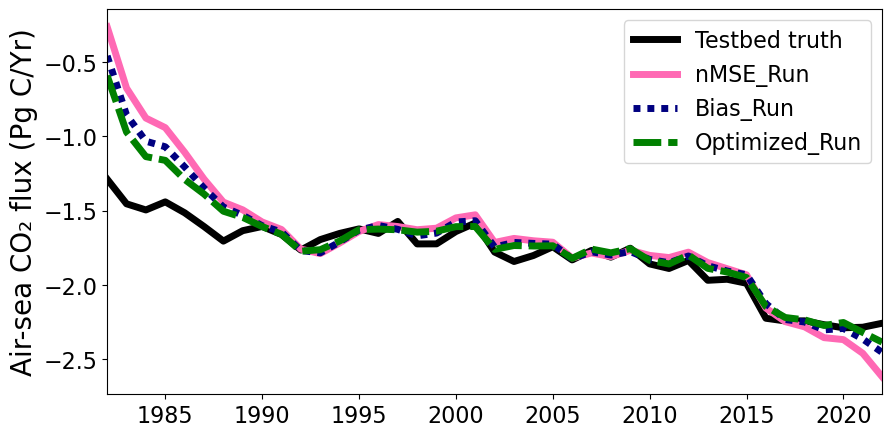

In [34]:
fig = plt.figure(figsize=(10,5))

plt.plot(annual_flux_truth_glob.year,annual_flux_truth_glob,linewidth=5.0,c='black',label='Testbed truth', linestyle='solid')
plt.plot(annual_flux_socat_glob.year,annual_flux_socat_glob,linewidth=5.0,c='hotpink',label='nMSE_Run', linestyle='solid')
plt.plot(annual_flux_bias_glob.year,annual_flux_bias_glob,linewidth=5.0,c='navy',label='Bias_Run', linestyle='dashed',dashes=(1,1))
plt.plot(annual_flux_optimized_glob.year,annual_flux_optimized_glob,linewidth=5.0,c='green',label='Optimized_Run', linestyle='dashed',dashes=(4,1))

plt.ylabel('Air-sea CO\u2082 flux (Pg C/Yr)', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.xlim(annual_flux_truth_glob.year[0],annual_flux_truth_glob.year[-1]);
plt.legend(fontsize=16);
#fig.savefig("/home/jovyan/timeseries_flux_testbed_globally.jpg",dpi=300, bbox_inches="tight")

## Figure S4

In [35]:
flux_map_truth = testbed_mean_flux_truth_xr.sel(time=slice("2022-01-01",'2022-12-31')).mean(['time'])
flux_map_socat = testbed_mean_flux_socat_baseline_xr.sel(time=slice("2022-01-01",'2022-12-31')).mean(['time'])
flux_map_bias = testbed_mean_flux_bias_xr.sel(time=slice("2022-01-01",'2022-12-31')).mean(['time'])
flux_map_optimized = testbed_mean_flux_optimized_xr.sel(time=slice("2022-01-01",'2022-12-31')).mean(['time'])

In [36]:
flux_map_change_socat = flux_map_socat - flux_map_truth 
flux_map_change_bias = flux_map_bias - flux_map_truth 
flux_map_change_optimized = flux_map_optimized - flux_map_truth 

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


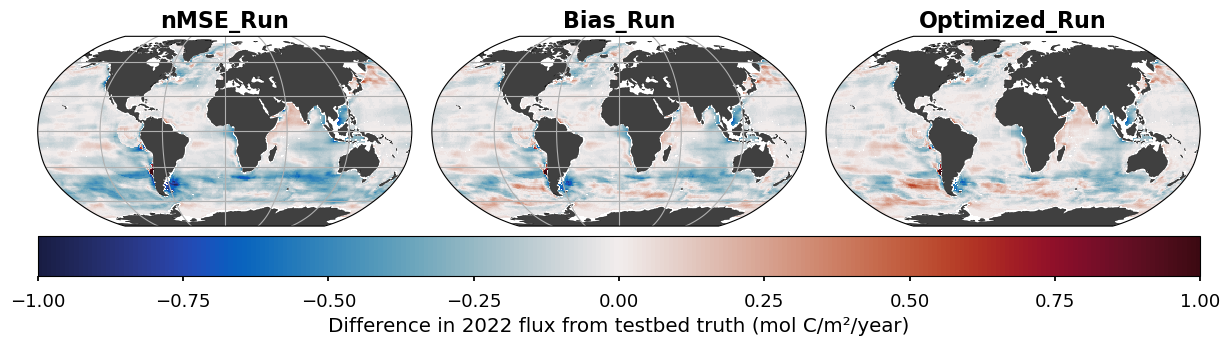

In [37]:
vrange = [-1, 1, 1]
fig_shape = (1,3)

cmap = cmocean.cm.balance
lab = f'Difference in 2022 flux from testbed truth (mol C/m²/year)'
   
      
with plt.style.context('seaborn-v0_8-talk'):
    fig = plt.figure(figsize=(15,5))

    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    sub = dia.add_plot(lat = flux_map_change_socat['ylat'], 
                           lon = flux_map_change_socat['xlon'], 
                           data = flux_map_change_socat, 
                           vrange=vrange[0:2],
                           cmap=cmap, 
                           ax=0)

    dia.set_title("nMSE_Run", 0, loc="center",fontsize=16, fontweight='bold')

    sub = dia.add_plot(lat = flux_map_change_bias['ylat'], 
                           lon = flux_map_change_bias['xlon'], 
                           data = flux_map_change_bias, 
                           vrange=vrange[0:2],
                           cmap=cmap, 
                           ax=1)

    dia.set_title("Bias_Run", 1, loc="center",fontsize=16, fontweight='bold')

    sub = dia.add_plot(lat = flux_map_change_optimized['ylat'], 
                           lon = flux_map_change_optimized['xlon'], 
                           data = flux_map_change_optimized, 
                           vrange=vrange[0:2],
                           cmap=cmap, 
                           ax=2)

    dia.set_title("Optimized_Run", 2, loc="center",fontsize=16, fontweight='bold')

    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    
    
    dia.grid[0].gridlines(draw_labels=False)
    dia.grid[1].gridlines(draw_labels=False)

#fig.savefig("/home/jovyan/flux_2022.jpg",dpi=300, bbox_inches="tight")